#### Full efficiency output for all 4 ports

In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad


#adding here ROI
emin = 1.55
emax = 1.65

### The functions exist here

In [5]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    

    if (verbose == True):
        print("Efficiency: {:.2f} %".format(efficiency))
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency




def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False, save_title = 'False'):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)

    if (save_title == 'False'):
        print("")
    else:
        plt.savefig(save_title)
        

    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return




def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.55, upper_e = 1.65, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df




def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))


def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

def read_MC_tracks(folder_path):
    '''
    Read in data from isaura events (MC and tracks)
    Checks the event mapping and adjusts if as expected
    '''

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # NOTE Break this section up, its annoying like this.
    dfs = []
    df_trs = []
    df_ems = []
    # create massive dataframe with all of them
    for file in file_names:
        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
        dfs.append(df)

        # include MC particles (boooo takes ages)

        # collecting the correct components of the file, not exactly sure how this works
        df_ps = pd.read_hdf(file_path, 'MC/particles')

        # collecting event map
        df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
        df_trs.append(df_ps)
        df_ems.append(df_em)

    tracks = pd.concat(dfs, axis=0, ignore_index=True)

    particles = pd.concat(df_trs, ignore_index=True)
    eventmap = pd.concat([dt for dt in df_ems])
    # create particle list also

    # check that the event map is as expected and modify to match MC to true data
    eventmap_reset = eventmap.reset_index()
    if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
        print("Event mapping no longer accurate between nexus and isaura events.\nPlease look at the eventmap object again")
    else:
        particles['event_id'] = particles['event_id'] * 2 
    
    # return 
    return (tracks, particles)


def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E


def apply_all_cuts(tracks, verbose = False, low_e_cut_plot = 'False'):
    '''
    Apply all relevant cuts
    
    returns efficiency table and the fully cut data
    
    
    This function makes me physically ill,
    but was made in a rush.
    Please rework this, for the love of god
    '''

    # Efficiency calculation
    cut_names = []
    rel_cut_effics = []
    abs_cut_effics = []
    cut_events = []


    # no cuts
    cut_names.append("No cuts")
    rel_cut_effics.append(100)
    abs_cut_effics.append(100)
    # number of events
    cut_events.append(len_events(tracks))

    low_e_cut_tracks = remove_low_E_events(tracks)


    # plot low e cut tracks if you want
    if (low_e_cut_plot == 'False'):
        print("")
    else:

        track_energy = low_e_cut_tracks.energy
        track_no = low_e_cut_tracks.numb_of_tracks
        # normalise
        weights = get_weights(track_energy, True)
        # clearing just in case
        plt.clf()
        # plot
        plt.hist2d(track_energy, track_no, weights = weights, bins=(100, tracks['numb_of_tracks'].max()), cmin=0.001)
        plt.title("Track energies: Low Pressure w/ low E cut: " + str(low_e_cut_plot))
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Number of tracks')
        plt.xlim([0,2.0])
        plt.colorbar()

        plt.savefig("trk_E_vs_no_trk_low_E.png")


        if (verbose == True):
            plt.show()


    # low energy cut
    cut_names.append("low E cuts")

    # make efficiency calculation
    if (verbose == True):
        print("Low E cut")
        print("==================")
        ef = cut_effic(low_e_cut_tracks, tracks, verbose = True)
    else:
        ef = cut_effic(low_e_cut_tracks, tracks)

    # add efficiency calculation
    rel_cut_effics.append(ef)
    cut_events.append(len_events(low_e_cut_tracks))
    abs_cut_effics.append(ef)



    cut_names.append("Fiducial Cuts")

    # make fiducial cuts
    fiducial_rel = fiducial_track_cut_2(low_e_cut_tracks, lower_z = 20, upper_z=1185, r_lim = 475, verbose = False)

    fiducial_abs = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1185, r_lim = 475, verbose = False)

    # make efficiency calculation
    if (verbose == True):
        print("Fiducial track cut")
        print("==================")
        print("Relative Cut efficiency:")
        ef = cut_effic(fiducial_rel, low_e_cut_tracks, verbose = True)
    else:
        ef = cut_effic(fiducial_rel, low_e_cut_tracks, verbose = False)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(fiducial_rel))

    if (verbose == True):
        print('Absolute Cut efficiency:')
        ef = cut_effic(fiducial_abs, tracks, verbose = True)
    else:
        ef = cut_effic(fiducial_abs, tracks, verbose = False)
    abs_cut_effics.append(ef)


    # relative single track
    cut_names.append("One track cut")
    one_track_rel = one_track_cuts(fiducial_rel, verbose = False)

    # events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
    one_track_abs = one_track_cuts(tracks)

    ## sanity check here
    #print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

    # relative
    if (verbose == True):
        print("Single track cut")
        print("================")
        print("Relative Cut efficiency:")
        ef = cut_effic(one_track_rel, fiducial_rel, verbose = True)
    else:
        ef = cut_effic(one_track_rel, fiducial_rel, verbose = False)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(one_track_rel))

    # absolute
    if (verbose == True):
        print("Absolute Cut efficiency:")
        ef = cut_effic(one_track_abs, tracks, verbose = True)
    else:
        ef = cut_effic(one_track_abs, tracks, verbose = False)
    abs_cut_effics.append(ef)


    # apply cuts
    ovlp_rel = overlapping_cuts(one_track_rel)
    ovlp_abs = overlapping_cuts(tracks)

    cut_names.append("Blob overlap cuts")

    
    # relative
    if (verbose == True):
        print("Blob overlap cut")
        print("================")
        print("Relative Cut efficiency:")
        ef = cut_effic(ovlp_rel, one_track_rel, verbose = True)
    else:
        ef = cut_effic(ovlp_rel, one_track_rel, verbose = False)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(ovlp_rel))


    # absolute
    if (verbose == True):
        print("Absolute Cut efficiency:")
        ef = cut_effic(ovlp_abs, tracks, verbose = True)
    else:    
        ef = cut_effic(ovlp_abs, tracks, verbose = False)
    abs_cut_effics.append(ef)


    # energy cuts
    ecut_rel = energy_cuts(ovlp_rel)
    ecut_abs = energy_cuts(tracks)

    cut_names.append("Energy cuts")

    # relative
    if (verbose == True):
        print("Energy cut")
        print("================")
        print("Relative Cut efficiency:")
        ef = cut_effic(ecut_rel, ovlp_rel, verbose = True)
    else:
        ef = cut_effic(ecut_rel, ovlp_rel, verbose = False)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(ecut_rel))


    # absolute
    if (verbose == True):    
        print("Absolute Cut efficiency:")
        ef = cut_effic(ecut_abs, tracks, verbose = True)
    else:
        ef = cut_effic(ecut_abs, tracks, verbose = False)
    abs_cut_effics.append(ef)


    efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Relative Events': cut_events,
                             'Single Cut Efficiency': abs_cut_effics
                             })

    if (verbose == True):
        display(efficiencies)
        print("Single Cut Efficiency: each cut on the original unmodified data set\nRelative Efficiency: each cut efficiency wrt the previous cut")


    # return it
    return (ecut_rel, efficiencies)


In [6]:
# list of folder paths for the different voxelisations
# NOTE If you want to change this, should do it here


folder_path = []
# port 1a, all voxelisations
# folder_path.append(['../LPR_rerun_voxel/isaura_15x15x15mm/PORT_1a/prod/isaura/','../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x5mm/PORT_1a/prod/isaura/'])
# # port 1b, all voxelisations
# folder_path.append(['../LPR_rerun_voxel/isaura_15x15x15mm/PORT_1b/prod/isaura/','../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1b/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x5mm/PORT_1b/prod/isaura/'])
# # port 2a, all voxelisations
# folder_path.append(['../LPR_rerun_voxel/isaura_15x15x15mm/PORT_2a/prod/isaura/','../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x5mm/PORT_2a/prod/isaura/'])
# # port 2b, all voxelisations
# folder_path.append(['../LPR_rerun_voxel/isaura_15x15x15mm/PORT_2b/prod/isaura/','../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2b/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x5mm/PORT_2b/prod/isaura/'])

folder_path.append(['../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1b/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2b/prod/isaura/'])


# flatten
folder_path = [x for xs in folder_path for x in xs]


folder_title = [ '10x10x10mm_Port_1a',   
                 '10x10x10mm_Port_1b',
                 '10x10x10mm_Port_2a', 
                 '10x10x10mm_Port_2b']



In [7]:
print(folder_path)
print(folder_title)

['../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1b/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2a/prod/isaura/', '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_2b/prod/isaura/']
['10x10x10mm_Port_1a', '10x10x10mm_Port_1b', '10x10x10mm_Port_2a', '10x10x10mm_Port_2b']


### Now to create the mega function

It will:
- Read in data (MC and Tracks)
- Apply the cuts and output the efficiencies
- Plot track energy vs # tracks

Iteratively

In [8]:

def process_efficiencies(folder_paths, folder_titles, verbose = True, low_e_plot = True):
    '''
    Function that read in MC and Track data from isaura files,
    Applies cuts and calculates the efficiencies, then plots
    track energy vs # of tracks and saves the main plots

    Also collects the histogram outputs for the energy distributions
    '''

    # make the directory to hold plots in
    directory_name = 'efficiency_study_plots'
    
    # list that holds all the efficiency tables as a tuple of (Name,efficiency_table)
    efficiency_objects = []
    # hold all the histogram outputs for the energy resolution
    hist_objects = []

    # loop over data
    for i in range(len(folder_paths)):

        
        ############################################################
        print("Processing {}...\n".format(folder_titles[i]))
        ############################################################


        # read in, this data will be rewritten each time
        tracks, particles = read_MC_tracks(folder_paths[i])

        if (verbose == True):
            print("================")
            print("  VERBOSE MODE  ")
            print("================")
            display(tracks.head())
            display(particles.head())
            display(tracks.tail())
            display(particles.tail())


        ############################################################
        print("Data read. Producing plots...\n")
        ############################################################


        # first we create track energies vs no of tracks plot
        track_energy = tracks.energy
        track_no = tracks.numb_of_tracks
        # normalise
        weights = get_weights(track_energy, True)
        # bins set up to match number of tracks
        plt.hist2d(track_energy, track_no, weights = weights, bins=(100, tracks['numb_of_tracks'].max()), cmin=0.001)
        plt.xlim([0,2.0])
        plt.title("Track energies LPR: Precuts - " + str(folder_titles[i]))
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Number of tracks')
        plt.colorbar()

        # save figure
        if not os.path.isdir(directory_name + '/' + folder_titles[i]):
            os.mkdir(directory_name + '/' + folder_titles[i])

        plt.savefig(directory_name + '/' + folder_titles[i] + '/' +str("trk_E_vs_no_trk.png"))
        
        # show plot
        if (verbose==True):
            plt.show()
        else:
            plt.close()


        ############################################################
        print("Applying efficiency cuts...\n")
        ############################################################
        # Efficiency calculation


        # dont look at this function if you want to retain brain cells
        if (low_e_plot == True):
            ecut_rel, efficiencies = apply_all_cuts(tracks, verbose = False, low_e_cut_plot = folder_titles[i])
            # move file
            os.replace("trk_E_vs_no_trk_low_E.png", directory_name + '/' + folder_titles[i] + '/' + "trk_E_vs_no_trk_low_E.png")
        else:
            ecut_rel, efficiencies = apply_all_cuts(tracks, verbose = False, low_e_cut_plot = 'False')
            

        # append with name as tuple
        efficiency_objects.append([folder_titles[i],efficiencies])

        ############################################################
        print("Producing more plots...\n")
        ############################################################
        
        name_save = str(directory_name) + '/' + str(folder_titles[i]) + '/' +str("Energy_plot.png")

        plt.close()
        hist_o = plot_hist(ecut_rel, binning = 75, title = 'Energy Plots' + str(folder_titles[i]), save_title = name_save, data = True)

        hist_objects.append([folder_titles[i], hist_o])
        if (verbose==True):
            plt.show()
        else:
            plt.close()
        

        # clean all variables here
        del hist_o
        del tracks
        del particles
        del ecut_rel
        del track_energy
        del track_no
        del weights



    ############################################################
    print("Job's done!")
    ############################################################

    return (efficiency_objects, hist_objects)


        


        

Processing 10x10x10mm_Port_1a...

Data read. Producing plots...

Applying efficiency cuts...



/tmp/ipykernel_27645/4173342283.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


Producing more plots...



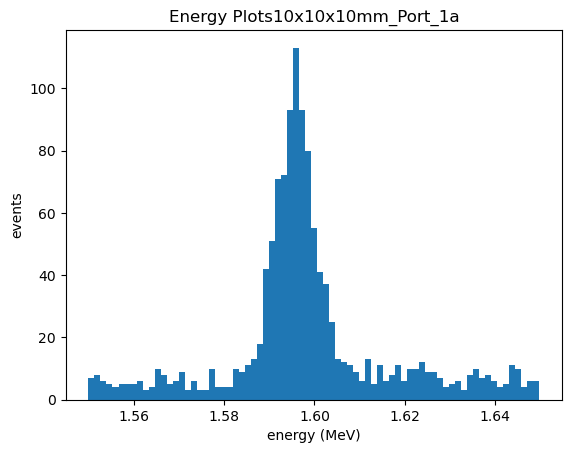

Processing 10x10x10mm_Port_1b...

Data read. Producing plots...

Applying efficiency cuts...

Producing more plots...



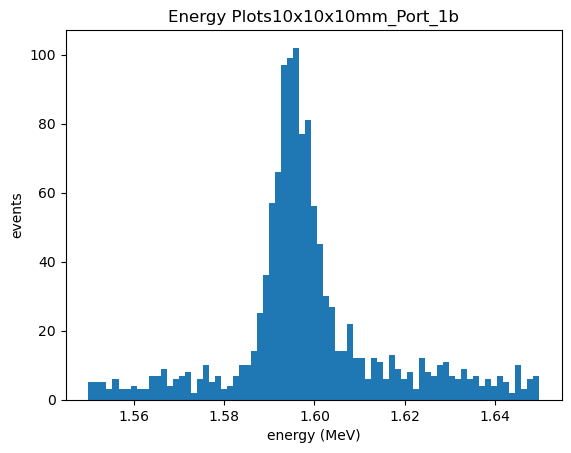

Processing 10x10x10mm_Port_2a...

Data read. Producing plots...

Applying efficiency cuts...

Producing more plots...



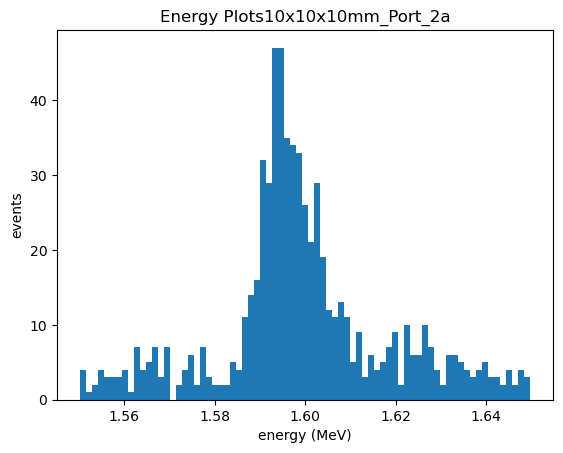

Processing 10x10x10mm_Port_2b...

Data read. Producing plots...

Applying efficiency cuts...

Producing more plots...



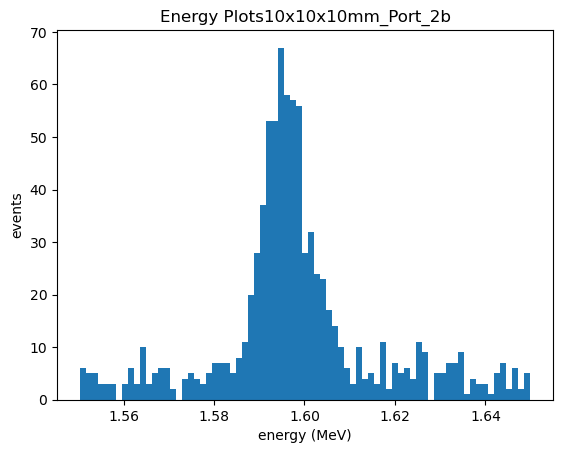

Job's done!


In [9]:
output_objects = process_efficiencies(folder_path, folder_title, verbose = False, low_e_plot = True)
plt.close()

In [10]:
print(output_objects[0][0])
display(output_objects[0][0][1])

['10x10x10mm_Port_1a',                  Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000           100009   
1         low E cuts            54.859063            54864   
2      Fiducial Cuts            73.031496            40068   
3      One track cut            49.613158            19879   
4  Blob overlap cuts            56.240254            11180   
5        Energy cuts            11.073345             1238   

   Single Cut Efficiency  
0             100.000000  
1              54.859063  
2              68.049876  
3              25.303723  
4              55.129038  
5               4.536592  ]


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,54.859063,54864,54.859063
2,Fiducial Cuts,73.031496,40068,68.049876
3,One track cut,49.613158,19879,25.303723
4,Blob overlap cuts,56.240254,11180,55.129038
5,Energy cuts,11.073345,1238,4.536592


In [11]:
print(folder_path[0])
print(folder_path[1])

../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/
../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1b/prod/isaura/


In [12]:
plt.close()

In [13]:
for i in range(len(output_objects[0])):
    print("==================")
    print("{}".format(output_objects[0][i][0]))
    print("==================")

    # save
    output_objects[0][i][1].to_csv('efficiency_study_tables/' + str(output_objects[0][i][0]) + '.csv')

    display(output_objects[0][i][1])

10x10x10mm_Port_1a


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,54.859063,54864,54.859063
2,Fiducial Cuts,73.031496,40068,68.049876
3,One track cut,49.613158,19879,25.303723
4,Blob overlap cuts,56.240254,11180,55.129038
5,Energy cuts,11.073345,1238,4.536592


10x10x10mm_Port_1b


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,95548,100.000000
1,low E cuts,59.877758,57212,59.877758
2,Fiducial Cuts,71.567154,40945,66.853309
3,One track cut,51.818293,21217,23.169506
4,Blob overlap cuts,57.694302,12241,56.540168
5,Energy cuts,10.203415,1249,4.720141


10x10x10mm_Port_2a


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,71041,100.000000
1,low E cuts,46.067764,32727,46.067764
2,Fiducial Cuts,71.796987,23497,66.950071
3,One track cut,50.474529,11860,31.120057
4,Blob overlap cuts,55.767285,6614,54.264439
5,Energy cuts,10.371938,686,4.008953


10x10x10mm_Port_2b


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,95437,100.000000
1,low E cuts,48.085124,45891,48.085124
2,Fiducial Cuts,72.811662,33414,68.369710
3,One track cut,48.605375,16241,28.445991
4,Blob overlap cuts,55.076658,8945,53.635383
5,Energy cuts,9.726104,870,4.139904


In [14]:
print(output_objects[1][1][0])
print(output_objects[1][1][1])
print("")
print(output_objects[1][1][1][0])
print("")
print(output_objects[1][1][1][1])
print("")
print(output_objects[1][2][0])

10x10x10mm_Port_1b
(array([  5.,   5.,   5.,   3.,   6.,   3.,   3.,   4.,   3.,   3.,   7.,
         7.,   9.,   4.,   6.,   7.,   8.,   2.,   6.,  10.,   5.,   7.,
         3.,   4.,   7.,  10.,  10.,  14.,  25.,  36.,  57.,  66.,  97.,
        99., 102.,  77.,  81.,  56.,  45.,  30.,  27.,  14.,  14.,  22.,
        12.,  12.,   6.,  12.,  11.,   6.,  13.,   9.,   6.,   8.,   3.,
        12.,   8.,   7.,  10.,  11.,   7.,   6.,   9.,   6.,   7.,   4.,
         6.,   4.,   7.,   5.,   2.,  10.,   3.,   6.,   7.]), array([1.55001118, 1.55134097, 1.55267076, 1.55400056, 1.55533035,
       1.55666014, 1.55798993, 1.55931972, 1.56064951, 1.5619793 ,
       1.56330909, 1.56463889, 1.56596868, 1.56729847, 1.56862826,
       1.56995805, 1.57128784, 1.57261763, 1.57394742, 1.57527722,
       1.57660701, 1.5779368 , 1.57926659, 1.58059638, 1.58192617,
       1.58325596, 1.58458575, 1.58591555, 1.58724534, 1.58857513,
       1.58990492, 1.59123471, 1.5925645 , 1.59389429, 1.59522408,
       1.5

(75,)
(75,)


<BarContainer object of 75 artists>

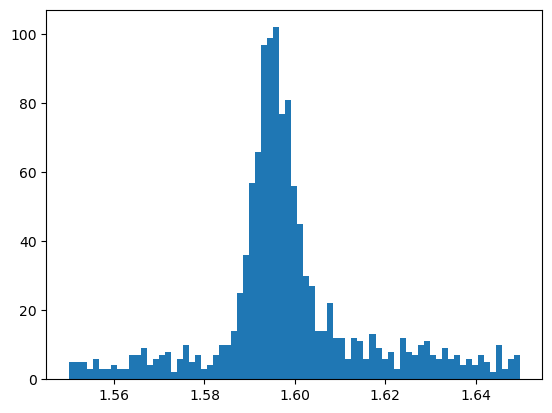

In [15]:
print((output_objects[1][1][1][0]).shape)
print(shift_to_bin_centers(output_objects[1][1][1][1]).shape)
plt.bar(shift_to_bin_centers(output_objects[1][1][1][1]), output_objects[1][1][1][0], width = np.diff(output_objects[1][1][1][1]))

In [16]:
print(output_objects[1])
print(output_objects[1])

[['10x10x10mm_Port_1a', (array([  7.,   8.,   6.,   5.,   4.,   5.,   5.,   5.,   6.,   3.,   4.,
        10.,   8.,   5.,   6.,   9.,   3.,   6.,   3.,   3.,  10.,   4.,
         4.,   4.,  10.,   9.,  11.,  13.,  18.,  42.,  51.,  71.,  72.,
        93., 113.,  93.,  80.,  55.,  41.,  37.,  25.,  13.,  12.,  11.,
         9.,   6.,  13.,   5.,  11.,   6.,   8.,  11.,   6.,  10.,  10.,
        12.,   9.,   9.,   7.,   4.,   5.,   6.,   3.,   8.,  10.,   7.,
         8.,   6.,   4.,   5.,  11.,  10.,   4.,   6.,   6.]), array([1.55001635, 1.551346  , 1.55267566, 1.55400531, 1.55533496,
       1.55666462, 1.55799427, 1.55932393, 1.56065358, 1.56198323,
       1.56331289, 1.56464254, 1.5659722 , 1.56730185, 1.5686315 ,
       1.56996116, 1.57129081, 1.57262047, 1.57395012, 1.57527977,
       1.57660943, 1.57793908, 1.57926874, 1.58059839, 1.58192805,
       1.5832577 , 1.58458735, 1.58591701, 1.58724666, 1.58857632,
       1.58990597, 1.59123562, 1.59256528, 1.59389493, 1.59522459,
     

In [17]:
#no_bars_list = [item for item in output_objects[1] if not any(isinstance(subitem, plt.container.BarContainer) for subitem in item)]
#print(no_bars_list)

In [18]:
print(output_objects[1][1][1])
print(output_objects[1][2][1][2])
print(output_objects[1][1][1][2])

(array([  5.,   5.,   5.,   3.,   6.,   3.,   3.,   4.,   3.,   3.,   7.,
         7.,   9.,   4.,   6.,   7.,   8.,   2.,   6.,  10.,   5.,   7.,
         3.,   4.,   7.,  10.,  10.,  14.,  25.,  36.,  57.,  66.,  97.,
        99., 102.,  77.,  81.,  56.,  45.,  30.,  27.,  14.,  14.,  22.,
        12.,  12.,   6.,  12.,  11.,   6.,  13.,   9.,   6.,   8.,   3.,
        12.,   8.,   7.,  10.,  11.,   7.,   6.,   9.,   6.,   7.,   4.,
         6.,   4.,   7.,   5.,   2.,  10.,   3.,   6.,   7.]), array([1.55001118, 1.55134097, 1.55267076, 1.55400056, 1.55533035,
       1.55666014, 1.55798993, 1.55931972, 1.56064951, 1.5619793 ,
       1.56330909, 1.56463889, 1.56596868, 1.56729847, 1.56862826,
       1.56995805, 1.57128784, 1.57261763, 1.57394742, 1.57527722,
       1.57660701, 1.5779368 , 1.57926659, 1.58059638, 1.58192617,
       1.58325596, 1.58458575, 1.58591555, 1.58724534, 1.58857513,
       1.58990492, 1.59123471, 1.5925645 , 1.59389429, 1.59522408,
       1.59655388, 1.59788367

In [19]:
# fix my stupid mistake

for i in range(len(output_objects[1])):
    output_objects[1][i][1] = (output_objects[1][i][1])[:-1]

print(output_objects[1][2][1])

(array([ 4.,  1.,  2.,  4.,  3.,  3.,  3.,  4.,  1.,  7.,  4.,  5.,  7.,
        3.,  7.,  0.,  2.,  4.,  6.,  2.,  7.,  3.,  2.,  2.,  2.,  5.,
        4., 11., 14., 16., 32., 29., 47., 47., 35., 34., 33., 26., 21.,
       29., 19., 12., 11., 13., 11.,  5.,  9.,  3.,  6.,  4.,  5.,  7.,
        9.,  2., 10.,  6.,  6., 10.,  7.,  4.,  2.,  6.,  6.,  5.,  4.,
        3.,  4.,  5.,  3.,  3.,  2.,  4.,  2.,  4.,  3.]), array([1.55014381, 1.5514731 , 1.55280239, 1.55413168, 1.55546097,
       1.55679026, 1.55811955, 1.55944884, 1.56077813, 1.56210742,
       1.56343671, 1.564766  , 1.56609529, 1.56742458, 1.56875387,
       1.57008316, 1.57141245, 1.57274174, 1.57407103, 1.57540032,
       1.57672961, 1.5780589 , 1.57938819, 1.58071748, 1.58204677,
       1.58337606, 1.58470535, 1.58603464, 1.58736393, 1.58869322,
       1.59002251, 1.5913518 , 1.59268109, 1.59401038, 1.59533967,
       1.59666896, 1.59799825, 1.59932754, 1.60065683, 1.60198612,
       1.60331541, 1.6046447 , 1.60597399, 1

In [20]:
print(type(output_objects))
import pickle
with open('histo_outputs.pickle', 'wb') as f:
    pickle.dump(output_objects, f)

<class 'tuple'>


In [21]:
with open('histo_outputs.pickle', 'rb') as f:
     data = pickle.load(f)

print(data[0])

[['10x10x10mm_Port_1a',                  Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000           100009   
1         low E cuts            54.859063            54864   
2      Fiducial Cuts            73.031496            40068   
3      One track cut            49.613158            19879   
4  Blob overlap cuts            56.240254            11180   
5        Energy cuts            11.073345             1238   

   Single Cut Efficiency  
0             100.000000  
1              54.859063  
2              68.049876  
3              25.303723  
4              55.129038  
5               4.536592  ], ['10x10x10mm_Port_1b',                  Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000            95548   
1         low E cuts            59.877758            57212   
2      Fiducial Cuts            71.567154            40945   
3      One track cut            51.818293            21217   
4  Blob overlap c

#### phew saved, now to plot the histograms as expected

In [34]:
# collect correct histo info
#print(output_objects[1][10])

# collecting 10x10x10

for i in range(len(output_objects[1])):
    print(output_objects[1][i][0])

outputs_10x10x10 = []

for i in range(len(output_objects[1])):
    
    if (((i-1)%3)==0):
        outputs_10x10x10.append(output_objects[1][i])

15x15x15mm_Port_1a
10x10x10mm_Port_1a
10x10x5mm_Port_1a
15x15x15mm_Port_1b
10x10x10mm_Port_1b
10x10x5mm_Port_1b
15x15x15mm_Port_2a
10x10x10mm_Port_2a
10x10x5mm_Port_2a
15x15x15mm_Port_2b
10x10x10mm_Port_2b
10x10x5mm_Port_2b


In [35]:
for i in range(len(outputs_10x10x10)):
    print(outputs_10x10x10[i][0])
    print(outputs_10x10x10[i][1][0])

10x10x10mm_Port_1a
[ 32.  22.  31.  26.  38.  26.  22.  23.  35.  17.  30.  27.  30.  32.
  27.  26.  25.  32.  25.  21.  23.  22.  30.  26.  17.  19.  20.  32.
  27.  32.  28.  36. 163. 493. 174.  52.  44.  47.  31.  30.  36.  20.
  22.  30.  24.  21.  35.  32.  27.  23.  17.  21.  29.  20.  15.  16.
  28.  27.  24.  21.  14.  18.  16.  21.  17.  22.  19.  12.  13.  14.
  22.  14.  13.  21.  20.]
10x10x10mm_Port_1b
[ 39.  33.  23.  39.  22.  23.  22.  28.  30.  39.  24.  28.  43.  25.
  24.  31.  28.  26.  28.  26.  21.  29.  25.  28.  29.  39.  26.  24.
  20.  34.  36.  32. 161. 493. 185.  69.  47.  40.  41.  28.  30.  28.
  25.  22.  31.  21.  22.  25.  30.  15.  21.  19.  20.  20.  18.  22.
  21.  25.  13.  20.  17.  28.  17.  20.  29.  25.  18.  25.  24.  15.
  20.  16.  15.  12.  10.]
10x10x10mm_Port_2a
[ 23.  22.  22.  19.  23.  17.  24.  19.  29.  14.  15.  25.  22.  26.
  26.  24.  21.  18.  18.  20.  19.  15.  14.  14.  11.  23.  23.  15.
  20.  27.  21.  13. 102. 216. 106.  

In [48]:
print(output_objects[1])

[['15x15x15mm_Port_1a', (array([ 13.,  20.,  17.,  14.,  13.,  14.,  16.,  12.,  20.,  11.,  12.,
        14.,  14.,  11.,   9.,  13.,  10.,  16.,  11.,  11.,  17.,  13.,
        13.,  19.,   6.,   9.,  18.,  20.,  17.,  17.,  11.,  14.,  93.,
       235.,  83.,  27.,  27.,  34.,  25.,  24.,  24.,  15.,  18.,  17.,
        13.,  19.,  18.,  21.,  18.,  11.,  13.,  12.,  13.,  12.,   9.,
        11.,  20.,  16.,  16.,  17.,   8.,  14.,  13.,  21.,  12.,  10.,
        12.,  11.,   9.,   6.,  12.,  14.,  10.,  12.,  16.]),)], ['10x10x10mm_Port_1a', (array([ 32.,  22.,  31.,  26.,  38.,  26.,  22.,  23.,  35.,  17.,  30.,
        27.,  30.,  32.,  27.,  26.,  25.,  32.,  25.,  21.,  23.,  22.,
        30.,  26.,  17.,  19.,  20.,  32.,  27.,  32.,  28.,  36., 163.,
       493., 174.,  52.,  44.,  47.,  31.,  30.,  36.,  20.,  22.,  30.,
        24.,  21.,  35.,  32.,  27.,  23.,  17.,  21.,  29.,  20.,  15.,
        16.,  28.,  27.,  24.,  21.,  14.,  18.,  16.,  21.,  17.,  22.,
        1

In [36]:
edgec = ['green', 'red', 'blue', 'black']
for i in range(len(outputs_10x10x10)):
    plt.bar(shift_to_bin_centers(outputs_10x10x10[i][1][1]), outputs_10x10x10[i][1][0], width = np.diff(output_objects[1][1][1][1]), label = outputs_10x10x10[i][0], fill = False, edgecolor = edgec[i], linewidth = 1.5)
plt.title('Energy distributions after cuts')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend()

IndexError: tuple index out of range